# Preprocesamiento de datos en MNE-Python

`
Autores:
Brigitte Aguilar, Sofía Poux, Elizabeth Young
`

Modificado de *PracticalMEEG2022: MNE-python hands-on tutorial*. Por Britta Westner. 

## Setup

Comenzaremos por cargar los paquetes que necesitaremos. Dentro de ellos se incluyen `matplotlib` para graficación, `os` para el manejo de directorios de archivos, `numpy` para operaciones numéricas y, por supuesto, `mne`.
También usaremos matplotlib magic para graficar las figuras en la misma notebook (inline). 

In [1]:
%matplotlib inline 
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
plt.style.use('ggplot')

Comprobemos nuevamente nuestra versión MNE-Python. Esto nos debería devolver 1.5.1 o una versión previa

In [2]:
mne.__version__

'1.5.1'

Configuramos el nivel de detalle de los mensajes de salida para que sea menos detallada:

In [3]:
mne.set_log_level('warning')

### Ayuda!

Recordá, si necesitas ayuda podés pedirla utilizando el signo de interrogación. 
Veamos cómo podemos obtener la documentación de una función. Por ejemplo, de la función `pick_types`.

In [ ]:
mne.pick_types?

## Estableciendo la ruta de los datos

En primer lugar, debes descargar la carpeta del dataset `Datos`. Luego, dejaremos a Python saber dónde encontrar esta carpeta en nuestro disco. Para ello, deberás modificar la ruta de abajo para que se ajuste a la estructura de la ruta de tu computadora!.
Podés imprimir la ruta completa para verificar que el directorio sea correcto. 

In [4]:
# Modificá la siguiente ruta según dónde se encuentre la carpeta Datos en tu disco
data_path = os.path.expanduser("~/Documents/MNE-projects/mne_tutorial_GardenOroVerde/Datos/")

raw_fname = os.path.join(data_path,
    'sub-01/sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif')

In [5]:
print(raw_fname)

C:\Users\Usuario/Documents/MNE-projects/mne_tutorial_GardenOroVerde/Datos/sub-01/sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif


Utilizá `bash` para verificar que la ruta se encuentra allí. Si esto te da un error, es problable que hayas cometido un error de tipeo en la ruta!

In [8]:
ls $raw_fname

El formato del par�metro no es correcto: "Documents".


## Acceso y lectura de los datos crudos

In [9]:
mne.io.read_raw_fif?

Signature:
mne.io.read_raw_fif(
    fname,
    allow_maxshield=False,
    preload=False,
    on_split_missing='raise',
    verbose=None,
)
Docstring:
Reader function for Raw FIF data.

Parameters
----------
fname : path-like | file-like
    The raw filename to load. For files that have automatically been split,
    the split part will be automatically loaded. Filenames should end
    with raw.fif, raw.fif.gz, raw_sss.fif, raw_sss.fif.gz, raw_tsss.fif,
    raw_tsss.fif.gz, or _meg.fif. If a file-like object is provided,
    preloading must be used.

    .. versionchanged:: 0.18
       Support for file-like objects.
allow_maxshield : bool | str (default False)
    If True, allow loading of data that has been recorded with internal
    active compensation (MaxShield). Data recorded with MaxShield should
    generally not be loaded directly, but should first be processed using
    SSS/tSSS to remove the compensation signals that may also affect brain
    activity. Can also be "yes" to load

In [6]:
raw = mne.io.read_raw_fif(raw_fname, preload=False)
print(raw)

<Raw | sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif, 404 x 540100 (491.0 s), ~6.9 MB, data not loaded>


In [7]:
raw

<Raw | sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif, 404 x 540100 (491.0 s), ~6.9 MB, data not loaded>

Para más información sobre cómo importar datos en MNE, visitá:
- para MEG: https://mne.tools/stable/auto_tutorials/io/plot_10_reading_meg_data.html
- para EEG: https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html

## Entendiendo el archivo de los datos

Veamos la información de las mediciones. Allí encontrarás detalles sobre:
   - frecuencia de muestreo
   - parámetros de filtrado
   - tipos de canales disponibles 
   - canales defectuosos
   - etc.

In [12]:
print(raw.info)

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 74 EEG, 3 Stimulus, 12 misc, 9 CHPI
 custom_ref_applied: False
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 356.4 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 404
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: []
 sfreq: 1100.0 Hz
 subject_info: 2 items (dict)
>


<div class="alert alert-success">
    <b>Ejercicio</b>:
     <ul>
    <li>¿Cuántos canales tenés para cada uno de los tipos de sensores?</li>
    <li>¿Cuál es la frecuencia de muestreo?</li>
    <li>¿Los datos fueron filtrados?</li>
    <li>¿Cuál es la frecuencia del ruido de línea?</li>
    <li>¿Existe algún canal defectuoso?</li>
    </ul>
</div>

## Una mirada más cercana al diccionario info

raw.info no es más que un diccionario:

In [13]:
isinstance(raw.info, dict)

True

Por lo tanto, podemos acceder a sus elementos de esta forma:

In [14]:
raw.info['sfreq']  # Frecuencia de muestreo

1100.0

In [15]:
raw.info['bads']  # lista de canales defectuosos

[]

In [16]:
raw.info['line_freq']  # frecuencia del ruido de línea

50.0

## Una mirada más cercana a los canales
Ahora veamos qué canales están presentes. Esto lo podemos ver a través del atributo `raw.ch_names`.

In [17]:
type(raw.ch_names)

list

In [18]:
raw.ch_names[:10]  # esto imprime los primeros 10 canales

['MEG0113',
 'MEG0112',
 'MEG0111',
 'MEG0122',
 'MEG0123',
 'MEG0121',
 'MEG0132',
 'MEG0133',
 'MEG0131',
 'MEG0143']

Podés indexarlos como una lista.

In [19]:
raw.ch_names[42]

'MEG0432'

También podemos consultar el tipo de canal de un canal específico:

In [20]:
channel_type = mne.io.pick.channel_type(raw.info, 75)
print('Canal #75 es de tipo:', channel_type)  # para imprimir de manera ordenada

channel_type = mne.io.pick.channel_type(raw.info, 320)
print('Canal #320 es de tipo:', channel_type)

Canal #75 es de tipo: grad
Canal #320 es de tipo: eeg


La información también contiene todos los detalles sobre los sensores (tipo, ubicaciones, marco coordenado, etc.) en `chs`:

In [21]:
len(raw.info['chs'])

404

In [22]:
type(raw.info['chs'])

list

In [23]:
raw.info['chs'][0]  # chequeamos el primer canal

{'scanno': 1,
 'logno': 113,
 'kind': 1 (FIFFV_MEG_CH),
 'range': 1.9073486328125e-05,
 'cal': 3.250000046861601e-09,
 'coil_type': 3012 (FIFFV_COIL_VV_PLANAR_T1),
 'loc': array([-0.1066    ,  0.0464    , -0.0604    , -0.01532829,  0.00619847,
        -0.99986327, -0.18597366, -0.98255992, -0.00331254, -0.98243302,
         0.185894  ,  0.016216  ]),
 'unit': 201 (FIFF_UNIT_T_M),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'MEG0113',
 'coord_frame': 1 (FIFFV_COORD_DEVICE)}

In [24]:
raw.info['chs'][330]

{'scanno': 331,
 'logno': 25,
 'kind': 2 (FIFFV_EEG_CH),
 'range': 0.00030517578125,
 'cal': 0.00019999999494757503,
 'coil_type': 1 (FIFFV_COIL_EEG),
 'loc': array([ 5.63842431e-02,  3.68367434e-02,  9.40217227e-02,  8.26010015e-04,
         1.14762366e-01, -2.10680366e-02,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]),
 'unit': 107 (FIFF_UNIT_V),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'EEG025',
 'coord_frame': 4 (FIFFV_COORD_HEAD)}

Ahora que sabemos que hay canales de EEG y MEG en los datos, podemos graficar ambos por separado. Las posiciones de los canales están disponibles en el atributo info del objeto raw, por lo tanto, podemos graficar las ubicaciones de los mismos directamente desde el objeto raw utilizando `plot_sensors()`.

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\2013439534.py:1: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  raw.plot_sensors(kind='topomap', ch_type='grad');


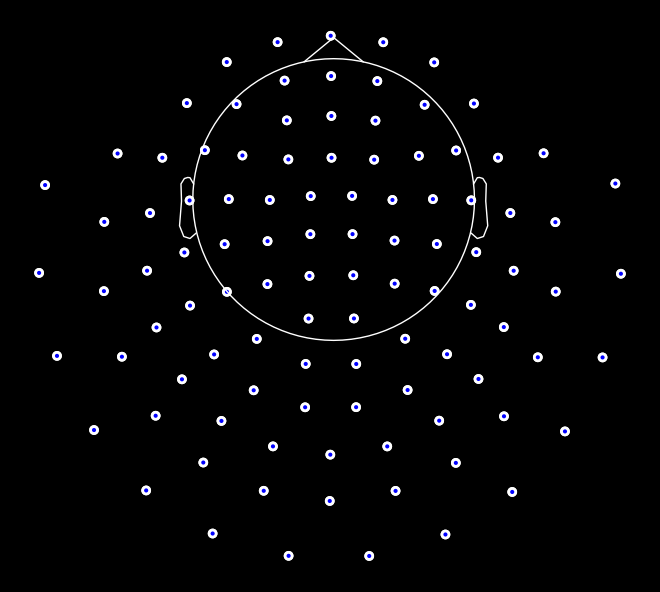

In [25]:
raw.plot_sensors(kind='topomap', ch_type='grad');

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\265059241.py:1: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  raw.plot_sensors(kind='topomap', ch_type='eeg');


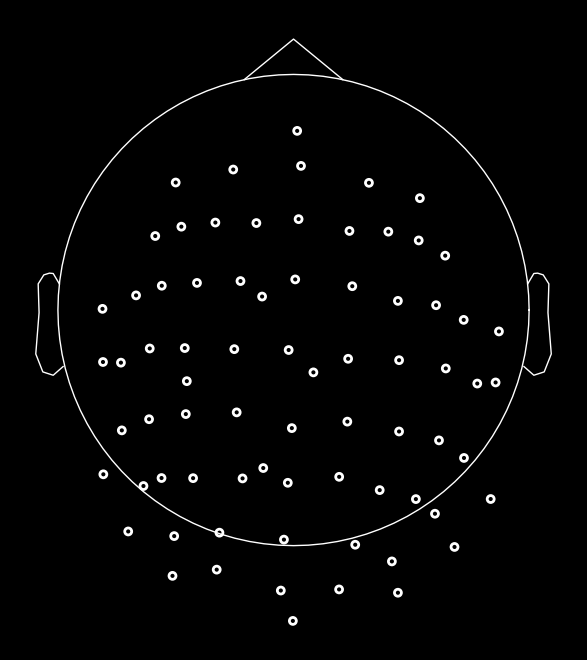

In [26]:
raw.plot_sensors(kind='topomap', ch_type='eeg');

## Configurando los tipos de canales y re-referenciando

Algunos canales están definidos erróneamente como EEG en el archivo. 
Dos de ellos son de EOG (EEG061 y EEG062) y EEG063 es una canal de ECG. EEG064 estaba registrando pero no estaba conectado a nada así que lo haremos `'misc'` en su lugar. 
Ahora configuraremos los tipos de canales para aquellos canales clasificados incorrectamente. Esto será útil para el rechazo automático de artefactos.

In [27]:
raw.set_channel_types?

Signature: raw.set_channel_types(mapping, *, on_unit_change='warn', verbose=None)
Docstring:
Specify the sensor types of channels.

Parameters
----------
mapping : dict
    A dictionary mapping channel names to sensor types, e.g.,
    ``{'EEG061': 'eog'}``.
on_unit_change : ``'raise'`` | ``'warn'`` | ``'ignore'``
    What to do if the measurement unit of a channel is changed
    automatically to match the new sensor type.

    .. versionadded:: 1.4

verbose : bool | str | int | None
    Control verbosity of the logging output. If ``None``, use the default
    verbosity level. See the :ref:`logging documentation <tut-logging>` and
    :func:`mne.verbose` for details. Should only be passed as a keyword
    argument.

Returns
-------
inst : instance of Raw | Epochs | Evoked
    The instance (modified in place).

    .. versionchanged:: 0.20
       Return the instance.

Notes
-----
The following sensor types are accepted:

    ecg, eeg, emg, eog, exci, ias, misc, resp, seeg, dbs, stim, sys

In [28]:
raw.set_channel_types({'EEG061': 'eog',  #  EOG no EEG
                       'EEG062': 'eog',  #  EOG no EEG
                       'EEG063': 'ecg',  #  ECG no EEG
                       'EEG064': 'misc'})  # EEG064 no conectado

# Renombramos los canales de EOG y ECG:
raw.rename_channels({'EEG061': 'EOG061',
                     'EEG062': 'EOG062',
                     'EEG063': 'ECG063'})

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\86333386.py:1: RuntimeWarning: The unit for channel(s) EEG064 has changed from V to NA.
  raw.set_channel_types({'EEG061': 'eog',  #  EOG no EEG


<Raw | sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif, 404 x 540100 (491.0 s), ~6.9 MB, data not loaded>

In [29]:
raw.info

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 70 EEG, 2 EOG, 1 ECG, 13 misc, 3 Stimulus, 9 CHPI
 custom_ref_applied: False
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 356.4 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 404
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: []
 sfreq: 1100.0 Hz
 subject_info: 2 items (dict)
>

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\265059241.py:1: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  raw.plot_sensors(kind='topomap', ch_type='eeg');


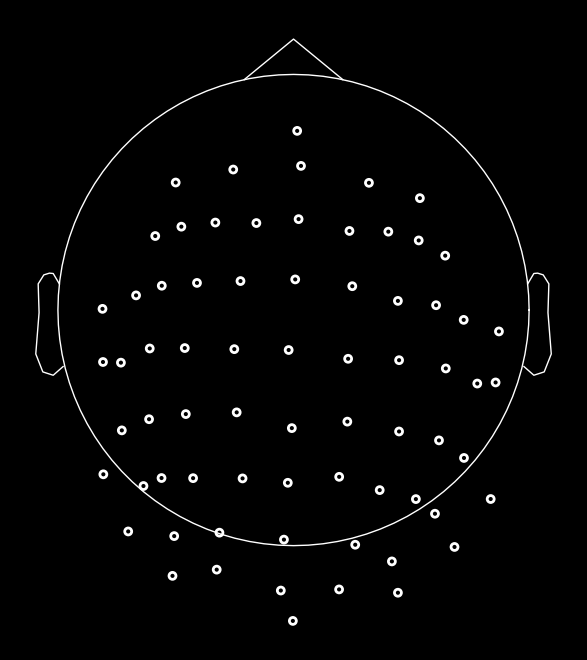

In [30]:
raw.plot_sensors(kind='topomap', ch_type='eeg');

Una vez que hayamos arreglado los canales, podemos re-referenciar los canales de EEG al promedio de los mismos. 

In [31]:
# Para configurar la referencia debemos cargar los datos en la memoria:
raw.load_data()
print(raw.info['custom_ref_applied'])  # veamos si existe una referencia

0 (FIFFV_MNE_CUSTOM_REF_OFF)


In [32]:
# ahora re-referenciamos
raw.set_eeg_reference(ref_channels='average', projection=False)
print(raw.info['projs'])  # no agregado como proyección
print(raw.info['custom_ref_applied'])

[]
1 (FIFFV_MNE_CUSTOM_REF_ON)


## Accediendo a los datos

Para acceder a los datos sólo debes utilizar `[]` tal como se accede a cualquier elemento de una lista, diccionario, etc. Vemos que `raw[]` devuelve dos cosas: los datos y un arreglo de instantes de tiempo.

In [33]:
start, stop = 0, 10
data, times = raw[:, start:stop]  # acceder a todos los canales para los primeros 10 instantes de tiempo
print(data.shape)
print(times.shape)

(404, 10)
(10,)


In [34]:
times  # siempre comienzan en 0 por convención

array([0.        , 0.00090909, 0.00181818, 0.00272727, 0.00363636,
       0.00454545, 0.00545455, 0.00636364, 0.00727273, 0.00818182])

Vimos que `raw[]` devuelve ambas cosas, los datos y los instantes de tiempo.

## Remuestreando los datos

Ahora cambiaremos la frecuencia de muestreo de los datos para acelerar los cálculos..

In [35]:
raw.load_data()  # cargar datos en memoria
raw.resample(300)

<Raw | sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif, 404 x 147300 (491.0 s), ~460.9 MB, data loaded>

Y eliminemos los canales innecesarios: algunos canales de estímulo vacíos, canales misc y canales HPI.

In [36]:
raw.drop_channels?

Signature: raw.drop_channels(ch_names, on_missing='raise')
Docstring:
Drop channel(s).

Parameters
----------
ch_names : iterable or str
    Iterable (e.g. list) of channel name(s) or channel name to remove.

on_missing : 'raise' | 'warn' | 'ignore'
    Can be ``'raise'`` (default) to raise an error, ``'warn'`` to emit a
    warning, or ``'ignore'`` to ignore when entries in ch_names are not present in the raw instance.

    .. versionadded:: 0.23.0

Returns
-------
inst : instance of Raw, Epochs, or Evoked
    The modified instance.

See Also
--------
reorder_channels
pick_channels
pick_types

Notes
-----
.. versionadded:: 0.9.0
File:      c:\users\admin\mne-python\1.5.1_0\lib\site-packages\mne\channels\channels.py
Type:      method

In [37]:
to_drop = ['STI201', 'STI301', 'MISC201', 'MISC202', 'MISC203',
           'MISC204', 'MISC205', 'MISC206', 'MISC301', 'MISC302',
           'MISC303', 'MISC304', 'MISC305', 'MISC306', 'CHPI001',
           'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005', 'CHPI006',
           'CHPI007', 'CHPI008', 'CHPI009']

In [38]:
raw.drop_channels(to_drop)

<Raw | sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif, 381 x 147300 (491.0 s), ~435.1 MB, data loaded>

## Filtrando los datos y graficando los datos crudos

Filtraremos los datos entre 0 y 40 Hz utilizando un filtro de respuesta finita al impulso (FIR) de fase lineal.

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>¿Qué parámetros debemos configurar para realizar dicho filtrado, basándonos en la documentación del método `filter`?</li>
    </ul>
</div>


In [39]:
raw.filter?

Signature:
raw.filter(
    l_freq,
    h_freq,
    picks=None,
    filter_length='auto',
    l_trans_bandwidth='auto',
    h_trans_bandwidth='auto',
    n_jobs=None,
    method='fir',
    iir_params=None,
    phase='zero',
    fir_window='hamming',
    fir_design='firwin',
    skip_by_annotation=('edge', 'bad_acq_skip'),
    pad='reflect_limited',
    verbose=None,
)
Docstring:
Filter a subset of channels.

Parameters
----------

l_freq : float | None
    For FIR filters, the lower pass-band edge; for IIR filters, the lower
    cutoff frequency. If None the data are only low-passed.

h_freq : float | None
    For FIR filters, the upper pass-band edge; for IIR filters, the upper
    cutoff frequency. If None the data are only high-passed.
picks : str | array-like | slice | None
    Channels to include. Slices and lists of integers will be interpreted as 
    channel indices. In lists, channel *type* strings (e.g., ``['meg', 
    'eeg']``) will pick channels of those types, channel *name

Para ver qué efecto tiene el filtrado en nuestros datos, primero grafiquemoslos rápidamente. Para una funcionalidad completa, le pedimos a matplotlib que muestre el gráfico en una ventana separada.

In [40]:
%matplotlib qt
raw.plot()

In [41]:
raw.filter(0, 40)

<Raw | sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif, 381 x 147300 (491.0 s), ~435.1 MB, data loaded>

Ahora que filtramos nuestros datos, veámoslos nuevamente. ¿Podés ver la diferencia?

In [42]:
raw.plot()

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li> ¿Qué señales cambiaron más debido al fitrado: EEG o MEG?</li>
      <li> ¿A qué podría deberse?</li>
      <li> ¿Observaste algún canal defectuoso?</li>
      <li> ¿Cuáles son las características más relevantes que podés observar en los datos?</li>
       </ul>
</div>

Para obtener más información sobre la visualización de datos crudos, consultá aquí: 
https://mne.tools/0.16/auto_tutorials/plot_visualize_raw.html


## Una mirada a la estructura de eventos de los datos

Los datos tienen diferentes eventos que marcan qué estímulo se presentó a los participantes. La estructura de evento/trigger es la siguiente:
- 5, 6, 7: rostros famosos
- 13, 14, 15: rostros no familiares
- 17, 18, 19: rostros mezclados

Primero veamos qué eventos hay:

In [43]:
events = mne.find_events(raw, stim_channel='STI101', verbose=True)

259 events found
Event IDs: [   5    6    7   13   14   15   17   18   19  256  261  262  263  269
  270  271  273  274  275 4096 4101 4102 4103 4109 4110 4111 4113 4114
 4115 4352]


In [44]:
events

array([[ 75052,      0,     13],
       [ 75336,      0,    256],
       [ 75964,      0,     14],
       [ 76158,     14,    270],
       [ 76896,      0,     13],
       [ 77798,      0,     13],
       [ 78755,      0,      5],
       [ 78984,      5,   4101],
       [ 79662,      0,     13],
       [ 80629,      0,      5],
       [ 80854,      5,   4101],
       [ 81602,      0,     17],
       [ 82529,      0,     15],
       [ 83506,      0,      5],
       [ 83720,      5,   4101],
       [ 84453,      0,     15],
       [ 85430,      0,     13],
       [ 85652,     13,    269],
       [ 86363,      0,     14],
       [ 86645,     14,    270],
       [ 87320,      0,      7],
       [ 87529,      7,   4103],
       [ 88317,      0,      5],
       [ 88593,      5,   4101],
       [ 89269,      0,     15],
       [ 89488,     15,   4111],
       [ 90217,      0,     17],
       [ 90499,     17,    273],
       [ 91209,      0,     18],
       [ 91433,     18,    274],
       [ 9

In [45]:
mne.count_events(events, ids=[5])

{5: 25}

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
    <li>¿De qué tipo es la variable events?</li>
    <li>¿Cuál es el significado de las tres columnas de events?</li>
    <li>¿Cuántos eventos con código 5 hay?
    </ul>
</div>

 

Hubo un retraso temporal de 34,5 ms en la presentación del estímulo. Por lo cual necesitamos corregir los eventos.

In [46]:
delay = int(round(0.0345 * raw.info['sfreq']))
events[:, 0] = events[:, 0] + delay

Visualicemos el paradigma:

In [47]:
events = events[events[:, 2] < 20]  # toma sólo los eventos con código menor a 20

In [48]:
fig = mne.viz.plot_events(events, raw.info['sfreq']);

Para etiquetar los eventos y condiciones utilizamos un diccionario de Python con claves que contienen "/" para agrupar subcondiciones.

In [49]:
event_id = {
    'face/famous/first': 5,
    'face/famous/immediate': 6,
    'face/famous/long': 7,
    'face/unfamiliar/first': 13,
    'face/unfamiliar/immediate': 14,
    'face/unfamiliar/long': 15,
    'scrambled/first': 17,
    'scrambled/immediate': 18,
    'scrambled/long': 19,
}

In [50]:
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          event_id=event_id);

Ahora podemos volver a ver nuestros datos crudos con las etiquetas de eventos modificadas:

In [51]:
raw.plot(event_id=event_id, events=events);

## Creación de épocas y rechazo de artefactos

Definimos los parámetros de las épocas:

In [52]:
tmin = -0.5  # comienzo de cada época (500ms antes del estímulo)
tmax = 2.0  # final de cada época (2000ms luego del estímulo)

Definimos el periodo de la línea de base (baseline):

In [53]:
baseline = (-0.2, 0)  # 200ms antes del comienzo del estímulo (t = 0)

Ahora elegimos los canales - MEG, EEG y EOG 

In [54]:
picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=True,
                       stim=False, exclude='bads')

La forma más fácil (¿y quizás también la más peligrosa?) de limpiar los datos es definir parámetros de rechazo de pico-a-pico (rango de amplitud) para gradiómetros, magnetómetros y EOG.

<div class="alert alert-info">
    <b>OBSERVACIÓN</b>:
     <ul>
    <li>El <a href="https://autoreject.github.io/">proyecto de rechacho automático</a> tiene como finalidad resolver este problema. Vea este <a href="https://www.sciencedirect.com/science/article/pii/S1053811917305013">paper</a> para más información.</li>
    </ul>
</div>

In [55]:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)  # esto puede ser altamente dependiente de los datos

Ahora podemos juntar todo esto y crear las épocas:

In [56]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject)

In [57]:
print(epochs)  # veamos algunos detalles del objeto epochs

<Epochs |  146 events (good & bad), -0.5 – 2 s, baseline -0.2 – 0 s, ~6.9 MB, data not loaded,
 'face/famous/first': 25
 'face/famous/immediate': 10
 'face/famous/long': 14
 'face/unfamiliar/first': 25
 'face/unfamiliar/immediate': 12
 'face/unfamiliar/long': 10
 'scrambled/first': 25
 'scrambled/immediate': 14
 'scrambled/long': 11>


Eliminemos explícitamente las épocas que identificamos como _malas_ a través de los umbrales que identificamos anteriormente:

In [58]:
epochs.drop_bad()  # rechaza las épocas malas mediante reject

Number of events,79
Events,face/famous/first: 13face/famous/immediate: 3face/famous/long: 6face/unfamiliar/first: 17face/unfamiliar/immediate: 4face/unfamiliar/long: 6scrambled/first: 15scrambled/immediate: 9scrambled/long: 6
Time range,-0.500 – 2.000 s
Baseline,-0.200 – 0.000 s


In [59]:
epochs.load_data()  # cargar datos en memoria

Number of events,79
Events,face/famous/first: 13face/famous/immediate: 3face/famous/long: 6face/unfamiliar/first: 17face/unfamiliar/immediate: 4face/unfamiliar/long: 6scrambled/first: 15scrambled/immediate: 9scrambled/long: 6
Time range,-0.500 – 2.000 s
Baseline,-0.200 – 0.000 s


## Una mirada más cercana al rechazo de artefactos


Primero, veamos cuáles son los métodos del objeto epochs.
Descomente la línea a continuación y escriba ``epochs.``, se desplegará la lista de métodos disponibles. 

In [60]:
#epochs.

Veamos cómo se eliminaron las épocas.

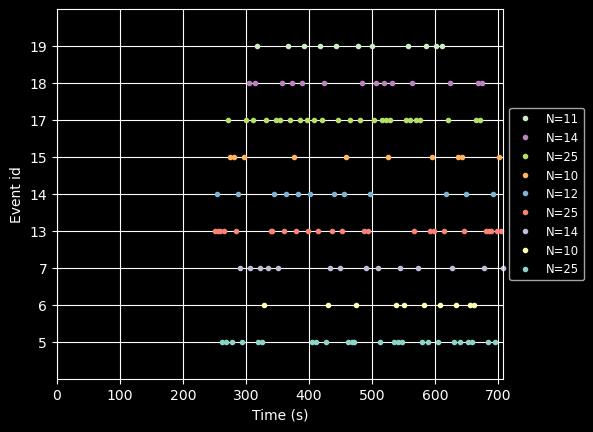

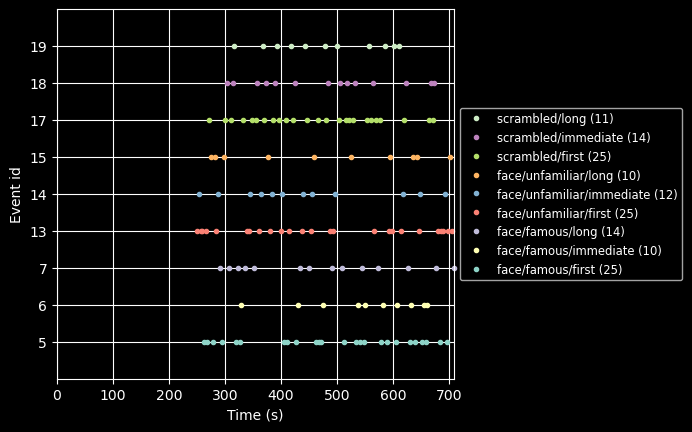

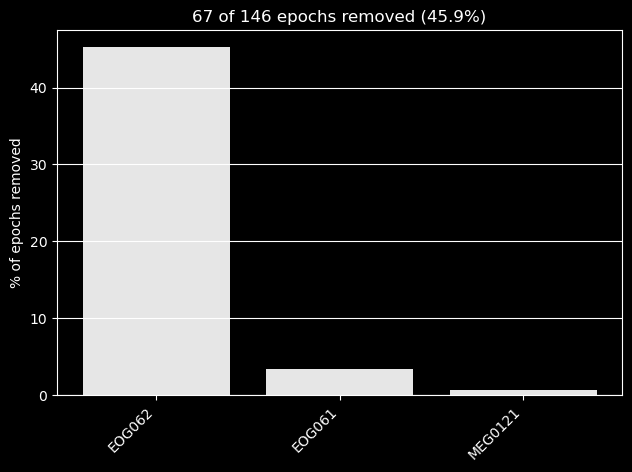

In [61]:
%matplotlib inline
epochs.plot_drop_log();

### Puede ser que..., ¿perdimos la mitad de nuestras épocas debido al EOG?

Probablemente podamos hacerlo mejor. Utilicemos la proyección espacial de señales (SSP) basada en PCA para eliminar los patrones espaciales relacionados con el EOG y el ECG.

Este es el flujo de trabajo: primero detectaremos artefactos de EOG y visualizaremos su impacto. Luego calcularemos patrones espaciales para mitigar estos artefactos.

In [64]:
# Hay una función para crear épocas EOG:
%matplotlib qt
eog_epochs = mne.preprocessing.create_eog_epochs(raw.copy().filter(1, None))
eog_epochs.average().plot_joint();

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\3487798407.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  eog_epochs.average().plot_joint();
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\3487798407.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  eog_epochs.average().plot_joint();
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\3487798407.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  eog_epochs.average().plot_joint();
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\3487798407.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  eog_epochs.average().plot_joint();
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\3487798407.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  eog_epochs.average().plot_joint();
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\3487798407.py:4: RuntimeWarning: (X, Y) 

Veamos dónde aparecen esos segmentos EOG en nuestros datos sin procesar:

In [65]:
%matplotlib qt
raw.plot(events=eog_epochs.events);

Calculemos las proyecciones de SSP basadas en el EOG:

In [66]:
projs_eog, _ = mne.preprocessing.compute_proj_eog(
    raw, n_mag=3, n_grad=3, n_eeg=3, average=True)

In [67]:
projs_eog  # veamos cómo son

[<Projection | EOG-planar--0.200-0.200-PCA-01, active : False, n_channels : 204, exp. var : 95.55%>,
 <Projection | EOG-planar--0.200-0.200-PCA-02, active : False, n_channels : 204, exp. var : 1.89%>,
 <Projection | EOG-planar--0.200-0.200-PCA-03, active : False, n_channels : 204, exp. var : 0.69%>,
 <Projection | EOG-axial--0.200-0.200-PCA-01, active : False, n_channels : 102, exp. var : 97.35%>,
 <Projection | EOG-axial--0.200-0.200-PCA-02, active : False, n_channels : 102, exp. var : 1.30%>,
 <Projection | EOG-axial--0.200-0.200-PCA-03, active : False, n_channels : 102, exp. var : 0.44%>,
 <Projection | EOG-eeg--0.200-0.200-PCA-01, active : False, n_channels : 70, exp. var : 99.67%>,
 <Projection | EOG-eeg--0.200-0.200-PCA-02, active : False, n_channels : 70, exp. var : 0.20%>,
 <Projection | EOG-eeg--0.200-0.200-PCA-03, active : False, n_channels : 70, exp. var : 0.05%>]

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\141627785.py:2: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_projs_topomap(projs_eog, info=epochs.info);
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\141627785.py:2: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_projs_topomap(projs_eog, info=epochs.info);
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\141627785.py:2: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_projs_topomap(projs_eog, info=epochs.info);
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\141627785.py:2: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_projs_topomap(projs_eog, info=epochs.info);


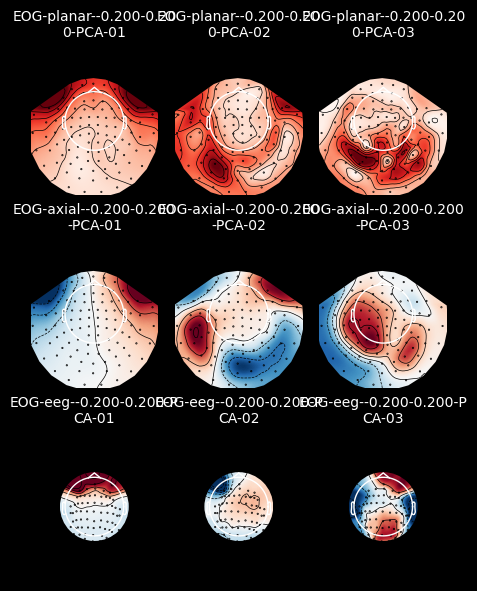

In [68]:
%matplotlib inline
mne.viz.plot_projs_topomap(projs_eog, info=epochs.info);

Ahora la pregunta importante es ¿cuántas componentes se deben conservar? Tip: algunas de ellas claramente no parecen patrones de artefactos.

La buena noticia es que no tenemos que decidir __*ahora*__ mismo. Como podemos ver las proyecciones están almacenadas con los datos pero inactivas por el momento. 

Repitamos el procedimiento esta vez para los artefactos de ECG, como son los latidos cardiacos.

In [69]:
# los mismo para el caso de ECG
%matplotlib qt
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw.copy().filter(1, None))
ecg_epochs.average().plot_joint()

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\472056752.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  ecg_epochs.average().plot_joint()
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\472056752.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  ecg_epochs.average().plot_joint()
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\472056752.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  ecg_epochs.average().plot_joint()
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\472056752.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  ecg_epochs.average().plot_joint()
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\472056752.py:4: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  ecg_epochs.average().plot_joint()
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\472056752.py:4: RuntimeWarning: (X, Y) fit (3.1, 3

[<Figure size 800x420 with 7 Axes>,
 <Figure size 800x420 with 7 Axes>,
 <Figure size 800x420 with 7 Axes>]

Podemos ver que también nos enfrentamos a contaminación con la señal cardíaca... eso también lo proyectaremos.

In [70]:
projs_ecg, _ = mne.preprocessing.compute_proj_ecg(
    raw, n_mag=3, n_grad=3, n_eeg=3, average=True)
mne.viz.plot_projs_topomap(projs_ecg, info=epochs.info);

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\178739447.py:3: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_projs_topomap(projs_ecg, info=epochs.info);
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\178739447.py:3: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_projs_topomap(projs_ecg, info=epochs.info);
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\178739447.py:3: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_projs_topomap(projs_ecg, info=epochs.info);
C:\Users\admin\AppData\Local\Temp\ipykernel_13076\178739447.py:3: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_projs_topomap(projs_ecg, info=epochs.info);


## Aplicando las proyecciones y visualizando el efecto

Ahora revirtamos nuestro rechazo de artefactos anterior y apliquemos las proyecciones en su lugar. 

In [71]:
#Eliminamos el EOG de nuestro rechazo aquí:
reject_no_eog = dict(mag=reject['mag'], grad=reject['grad']) 

epochs_clean = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                          picks=picks, baseline=baseline,
                          preload=False,
                          reject=reject_no_eog)

# y luego agregamos las proyecciones de EOG y ECG (¡pero aún no las aplicamos!)
epochs_clean.add_proj(projs_eog + projs_ecg)


Number of events,146
Events,face/famous/first: 25face/famous/immediate: 10face/famous/long: 14face/unfamiliar/first: 25face/unfamiliar/immediate: 12face/unfamiliar/long: 10scrambled/first: 25scrambled/immediate: 14scrambled/long: 11
Time range,-0.500 – 2.000 s
Baseline,-0.200 – 0.000 s


Veamos un canal MEG frontal antes de aplicar las proyecciones:

In [72]:
epochs_clean.plot_image(picks='MEG0123', sigma=1.);

¡Ahora apliquemos las proyecciones a una copia y grafiquemos este canal nuevamente!

In [73]:
epochs_proj = epochs_clean.copy().apply_proj()  # aplicamos las proyecciones a una copia

epochs_proj.plot_image(picks='MEG0123', sigma=1.);

Antes establecimos que probablemente no todas las proyecciones capturan parpadeos y artefactos cardíacos. ¡Así que repitamos este procedimiento pero solo proyectemos la _primera_ proyección por tipo de canal!

In [80]:
%matplotlib qt
epochs_clean.del_proj()
epochs_clean.add_proj(projs_eog[::3] + projs_ecg[::3])  # añadimos solo algunas proyecciones SSP
epochs_proj = epochs_clean.copy().apply_proj()  # aplicamos proyecciones a una copia

epochs_proj.plot_image(picks='MEG0123', sigma=1.);

In [75]:
epochs_proj.info

<Info | 25 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 70 EEG, 2 EOG
 custom_ref_applied: True
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 378
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: EOG-planar--0.200-0.200-PCA-01: on, EOG-axial-- ...
 sfreq: 300.0 Hz
 subject_info: 2 items (dict)
>

De esta manera, ahora mantenemos todas las épocas (trials), pero eliminamos los parpadeos y los artefactos cardíacos. Ahora guardaremos los datos con las proyecciones SSP _no aplicadas_.

<div class="alert alert-info">
    <b>OBSERVACIÓN</b>:
     <ul>
    <li>MNE mantiene las proyecciones SSP dentro de la información y permite aplicarlas más tarde.</li>
    </ul>
</div>

#### Algunas reflexiones sobre el rechazo de artefactos

En este ejemplo abordamos los artefactos en este conjunto de datos calculando proyecciones SSP. Sin embargo, hay muchas otras formas de rechazar artefactos:

- marcar artefactos manualmente (inspección visual)
- utilizar umbrales (lo cual falló para estos datos)
- utilizar ICA
- utilizar un pipeline automatizado, por ejemplo el <a href="https://autoreject.github.io/">autoreject project</a>
- etc.

La mejor recomendación es: familiarizate con tus datos (crudos)! 

## Guardando las épocas

In [81]:
# sobreescribamoslas
epochs = epochs_clean

La forma estándar es guardar las épocas como un archivo `.fif` junto con todos los datos del encabezado. Las épocas se guardan con el sufijo `-epo.fif`.

In [82]:
epochs_fname = raw_fname.replace('_meg.fif', '-epo.fif')  # creamos el nombre del archivo
epochs_fname

'C:\\Users\\admin/Documents/MNE projects/mne_pratical_meeg_2022-main/ds000117_pruned/derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss-epo.fif'

In [ ]:
epochs.save(epochs_fname, overwrite=True) 

## Extra: visualización de  épocas

Vea [ésta página](https://mne.tools/stable/auto_tutorials/epochs/20_visualize_epochs.html) para las opciones de visualización de épocas.

In [83]:
# Ya hemos visto las épocas en un gráfico apilado:

epochs_proj.plot_image(picks='EEG065', sigma=1.);

También podemos ver las épocas en una ventana del navegador de datos:

In [84]:
%matplotlib qt
epochs.plot();

C:\Users\admin\AppData\Local\Temp\ipykernel_13076\2738299910.py:2: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  epochs.plot();


In [85]:
epochs.info

<Info | 25 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 70 EEG, 2 EOG
 custom_ref_applied: True
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 378
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: EOG-planar--0.200-0.200-PCA-01: off, EOG-axial-- ...
 sfreq: 300.0 Hz
 subject_info: 2 items (dict)
>